# Install dependencies

In [1]:
!pip install tensorflow-gpu==2.1

     |████████████████████████████████| 421.8MB 26kB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 3.9MB 31.7MB/s 
     |████████████████████████████████| 450kB 40.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=be12c19b1f3b7c66a9f89a77bf7ba0de42bef9a4887bfbf40cbb7a3bb2a5dbde
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

# Connect google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
'Colab Notebooks'	 im.png			  Warsaw_house_prices
 CV_Kacper_Wachnik.pdf	 Mister_car
 Digits_ocr		 UdemyMachineLearningAZ


# Import libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from scipy import misc
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import h5py

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Embedding, TimeDistributed, \
Conv2D, MaxPooling2D, GlobalMaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw, ImageFont

import os
from os import path
import random
from random import shuffle, randint
import glob
import shutil

import pickle
import gzip

# Setting useful constants

In [4]:
%pwd

'/content'

In [8]:
if path.exists('speed_screenshots'):
    shutil.rmtree('speed_screenshots')
else:
    os.mkdir('speed_screenshots')

training_data_path = "speed_screenshots"
training_folders = os.listdir(training_data_path)

vocab = ['s', '0', '1', '2', '3', '4', '5', '6',
            '7', '8', '9', 'e']

ixtoword = {}
wordtoix = {}
ix = 0
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword)
print(wordtoix)

# max length of the digit sequence
max_length = 6

{'s': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'e': 11}


# Create synthetic data using different fonts

In [ ]:
%pwd

'/content'

In [10]:
SAMPLES = 100

#random.seed(42)

X1_synt, X2_synt, y_synt = list(), list(), list()

for s in range(1000):

    # random background
    R = random.randint(0, 20)
    G = random.randint(0, 20)
    B = random.randint(0, 20)
    img = Image.new('RGB', (50, 25), color = (R, G, B))
    
    # choose font
    font_size = random.randint(8, 16)
    #fnt = ImageFont.truetype('/mydrive/Digits_ocr/arial.ttf', font_size)
    fnt = ImageFont.truetype('/mydrive/Digits_ocr/digitaldream.ttf', font_size)

    digits = randint(1,int(50/font_size))

    number = ""
    for j in range(digits):
        dgt = random.randint(0, 9)
        number += str(dgt)

    # draw number
    start_x, start_y = random.randint(16-font_size, 18-font_size), random.randint(2, 4)
    d = ImageDraw.Draw(img)
    R = random.randint(150, 255)
    G = random.randint(150, 255)
    B = random.randint(150, 255)
    d.text((start_x, start_y), number, font=fnt, fill=(R, G, B))

    f = number

    # encode the sequence
    seq = [wordtoix[word] for word in f if word in wordtoix]
    seq.insert(0, 0)
    seq.append(11)
    #print('seq = ', seq)
    # split one sequence into multiple X, y pairs
    for i in range(1, len(seq)):
    # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        X1_synt.append(np.asarray(img))
        X2_synt.append(in_seq)
        y_synt.append(out_seq)

X1_synt = np.array(X1_synt)
X2_synt = np.array(X2_synt)
y_synt = np.array(y_synt)

print(X1_synt.shape)
print(X2_synt.shape)
print(y_synt.shape)

(3507, 25, 50, 3)
(3507, 6)
(3507, 12)


# Load your real, custom data

In [11]:
%pwd

'/content'

In [ ]:
!7za x /mydrive/Digits_ocr/speed_screenshots.7z
!ls

X1_real, X2_real, y_real, X2_help, y_help = list(), list(), list(), list(), list()

training_folders = os.listdir('speed_screenshots')
print("Training folders = ", training_folders)
for f in training_folders:

    # encode the sequence
    seq = [wordtoix[word] for word in f if word in wordtoix]
    seq.insert(0, 0)
    seq.append(11)
    #print('seq = ', seq)
    # split one sequence into multiple X, y pairs
    for i in range(1, len(seq)):
    # split into input and output pair
        in_seq, out_seq = seq[:i], seq[i]
        # pad input sequence
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        # encode output sequence
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        # store
        X2_help.append(in_seq)
        y_help.append(out_seq)

    training_files = os.listdir('speed_screenshots/' + f)
    number_of_files = len(training_files)
    in_out_len = len(X2_help)

    for image in training_files:
        for i in range(in_out_len):
            path = 'speed_screenshots/' + f + '/' + image
            im = cv2.imread(path)

            if im is not None:
                X1_real.append(im)
                X2_real.append(X2_help[i])
                y_real.append(y_help[i])

X1_real = np.array(X1_real)
X2_real = np.array(X2_real)
y_real = np.array(y_real)

print(X1_real.shape)
print(X2_real.shape)
print(y_real.shape)

# Normalize the data

In [12]:
def normalize_data(img_data):
    #Converting everything to floats
    img_data = img_data.astype('float32')
    #Normalizing values between 0 and 1
    img_data /= 255
    return img_data

X1_synt = normalize_data(X1_synt)
#X1_real = normalize_data(X1_real)

# Model building

In [14]:
# input image
inputs_img = tf.keras.Input(shape=(25, 50, 3))

# convolution model
x = Conv2D(16, kernel_size=(3, 3), strides=2, 
           padding='valid', activation='relu')(inputs_img)
x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                 padding='valid', data_format=None)(x)

x = Conv2D(32, kernel_size=(3, 3), strides=1, 
           padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                 padding='valid', data_format=None)(x)

x = Conv2D(64, kernel_size=(3, 3), strides=1, 
           padding='valid', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), 
                 padding='valid', data_format=None)(x)

# fully connected
x = Flatten()(x)
fe1 = Dropout(0.5)(x)
fe2 = Dense(64, activation='relu')(fe1)

# partial caption sequence model
vocab_size = 12
max_length = 6
embedding_dim = 50

inputs_seq = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim)(inputs_seq) #, mask_zero=True
mask = tf.keras.layers.Masking(mask_value=0)(se1)
se2 = Dropout(0.5)(mask)
se3 = LSTM(64)(se2)

# decoder (feed forward) model
decoder1 = tf.keras.layers.concatenate([fe2, se3])
decoder2 = Dense(64, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs_img, inputs_seq], outputs=outputs)

model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 24, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 22, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 20, 32)    4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

# Visualization the network model using graphviz

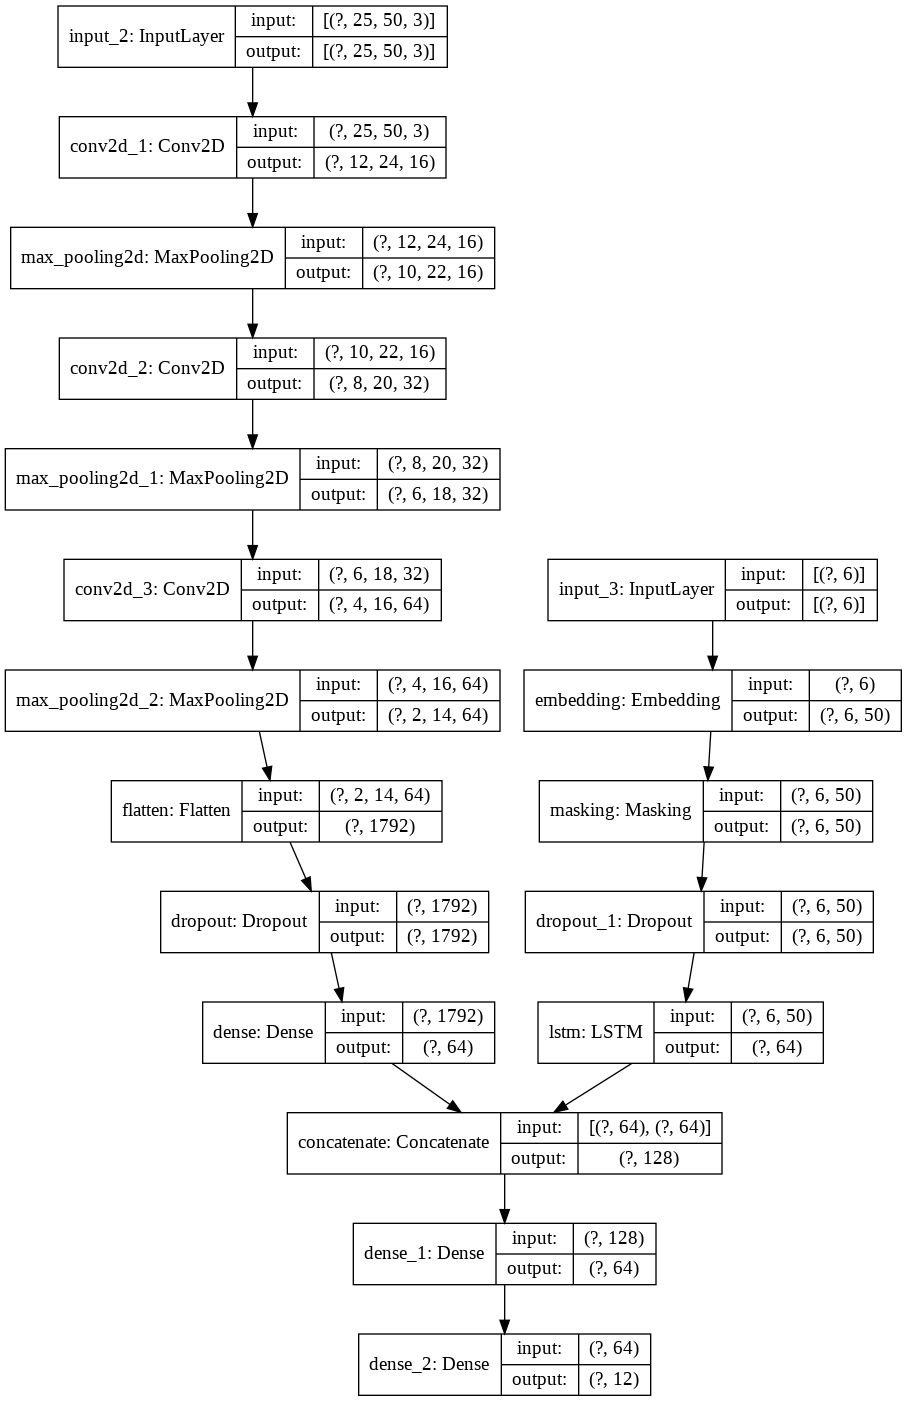

In [15]:
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import Image, SVG
plot_model(model, to_file='model.png',show_shapes=True)
Image('model.png')

# Train

In [26]:
# Data augmentation on the fly
# aug = ImageDataGenerator(
# 		rotation_range=10,
# 		zoom_range=0.10,
# 		width_shift_range=0.1,
# 		height_shift_range=0.1,
# 		shear_range=0.05,
# 		horizontal_flip=False,
# 		fill_mode="nearest")

#Train the neural network.
model.fit(x=[X1_synt, X2_synt], y=y_synt,
	  	  #x=aug.flow( [np.array(X1), np.array(X2)], y=y_train ),
          epochs=5,
          #batch_size=128,
          shuffle=True,
		  #validation_data=([X1_real, X2_real], y_real)
          validation_split=0.2
          )

Train on 2805 samples, validate on 702 samples
Epoch 1/5
2805/2805 [==============================] - 1s 423us/sample - loss: 0.3002 - accuracy: 0.8941 - val_loss: 0.7144 - val_accuracy: 0.7664
Epoch 2/5
2805/2805 [==============================] - 1s 406us/sample - loss: 0.2987 - accuracy: 0.8938 - val_loss: 0.7081 - val_accuracy: 0.7650
Epoch 3/5
2805/2805 [==============================] - 1s 422us/sample - loss: 0.2758 - accuracy: 0.9030 - val_loss: 0.7210 - val_accuracy: 0.7792
Epoch 4/5
2805/2805 [==============================] - 1s 422us/sample - loss: 0.2656 - accuracy: 0.9005 - val_loss: 0.7287 - val_accuracy: 0.7664
Epoch 5/5
2805/2805 [==============================] - 1s 407us/sample - loss: 0.2588 - accuracy: 0.9119 - val_loss: 0.7115 - val_accuracy: 0.7721


# Predict

In [28]:
def greedySearch(photo):
    in_text = 's'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += '' + word
        if word == 'e':
            break
    final = in_text
    final = final[1:-1]
    final = ' '.join(final)
    return final

# check on synthetic data
image = X1_synt[150]
imageCopy = image.copy()
imageCopy *= 255
if not cv2.imwrite('/mydrive/im.png', imageCopy):
    raise Exception("Could not write image")

# check on your real, custom data
# image = cv2.imread('speed_screenshots/33/screenshot1036.jpg')
# imageCopy = image.copy()
# if not cv2.imwrite('/mydrive/im.png', imageCopy):
#     raise Exception("Could not write image")
# image = normalize_data(image)

# prepare for the inference
image = image.reshape(-1, 25, 50, 3)

if image is not None:
    print("Greedy:", greedySearch(image))
else:
    print('Dupa')

Greedy: 2 8


# Save the model

In [29]:
model.save_weights('/mydrive/Digits_ocr/model.h5')